# w207 Spring 2019 - Final Project: Facial Keypoints Detection

by Michael Berger, Andre Fernandes, Vivian Lu, Sam Tosaria, and Pauline Wang.

Date: April 14, 2019

**Note:** As the CNN models' training require high training time, we used a GPU and saved the model objects in a repository. In addition, most of our code is functionalized and stored in `Berger_Fernandes_Lu_Tosaria_Wang_Baseline.py` which we load into this notebook. This allowed us to work more collaboratively on the code and also keep this notebook clean.

# Abstract

This report summarizes our approach towards predicting facial keypoints from a given set of images in the Kaggle facial keypoint detection challange.  We first approached the problem with a baseline model which is a regression model, and enhanced our model performance by introducing convolutional neutral networks (CNN) as well as increasing variance e.g. by adding dropouts.  We were able to improve the model performance by changing the model infrastructure (64% improvement from baseline). In an attempt to further increase the performance, we tried using image data enhancement methods, like stretching, flipping, rotating etc, in order to generate more training data for our models. A challange here was to retrieve the stretched, flipped, rotated coordinate points. For a range of operations, besides horizontal flipping, we were able to retrieve the points and hence increase our training set. It indeed gave us the best performance on the Kaggle test set and the best place on the leaderboard (public leaderboard: 69th/ private leaderboard: 79th). We then trained the enhanced CNN model on this set. Finally, we created an ensemble model to expand on the Kaggle challange: In reality it is not known which keypoints are present. The ensemble model should classify the presence of keypoints and then predict their location.

We learned from this project that modeling is easy but understanding the subtlety of the underlying data is challenging.


# Introduction

The goal of our project is to build a well-performing machine learning algorithm to determine 15 facial keypoints from an image of a human face.  The data we use for training and testing is from the Kaggle [facial keypoint detection competition](https://www.kaggle.com/c/facial-keypoints-detection), which consists of 7000+ facial images of men, women and children.   

We have, essentially, a regression problem. Each facial keypoint has an x and y coordinate, leading up to 30 variables that need to be predicted using 96x96 pixel values from an image. However, due to multiple angles, orientations, and resolutions in our training images, the problem becomes particularly challenging to solve with simply a regression algorithm. 

Our approach utilizes a combination of **data augmentation and Convolutional Neural Networks (CNN)** to build a machine learning model. As a baseline, we use a simple CNN with no hidden layer, trained on the raw images with complete labels only. The metric we used for measuring error is the same as the Kaggle competition: the **root mean squared error (RMSE)** which is defined as:

$RMSE = \sqrt{ \frac{1}{n} \sum^n_{i=1} (y_i - \hat{y}_i)^2}$

The RMSE measures the average distance of each team's model predictions from the true coordinates of the 15 keypoints on the face.  For example, an RMSE of 3.00 means that, on average, the predictions are three pixels away from the true keypoint x or y coordinate. However, it needs to be noted that this metric punishes high errors more severly than other metrics.

## Report Outline

Our analysis as summarized in this Jupyter Notebook is structured as follows: The first part illustrates an exploratory data analysis and the buildling of our baseline models to identify obstacles and challenges with the project. The second part depicts our thought process and methods to tackle these challenges.  

**Part I**

- Exploration Data Analysis (EDA)

- Baseline Model
    - Data Tranformation
    - Model Buildling
    - Sectional Summary
        - Challenge 1: Suboptimal model performance
        - Challenge 2: Insufficient training data
        - Challenge 3: Inconsistent image quality
    
**Part II**

- Challange 1 & 3: Extension of Neural Network to a CNN
    - Extension of model architecture
    - Addding Dropout and Batch Normalization

- Challange 2 & 3: Data Augmentation
    - Data Generator
    - Imputing missing coordinates
    - Extended CNN model with Dropout and Batch Normalization trained on augmented data

- Extension: Ensemble Model - Combining Classification and Regression Models
    - Classification CNN
    - Combining predictions

- Model Performance Evaluation and Kaggle Submission

- Conclusion
 

***

# Part I

## Exploration Data Analysis

We first import all the libaries required to build our models and then load the data. 

In [1]:
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')
import importlib
import Berger_Fernandes_Lu_Tosaria_Wang_Baseline as facial_functions
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from IPython.display import Image
workDir = os.getcwd()

Using TensorFlow backend.


In [20]:
df_train, df_test = facial_functions.read_train_and_test(
                                        os.path.join(workDir, "data", "training.csv"),
                                        os.path.join(workDir, "data", "test.csv"))

# Not displaying the last image column (for display purposes)
df_train.loc[:,'left_eye_center_x':'mouth_center_bottom_lip_y'].head(10)

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   
2          65.057053          34.909642           30.903789   
3          65.225739          37.261774           32.023096   
4          66.725301          39.621261           32.244810   
5          69.680748          39.968748           29.183551   
6          64.131866          34.290040           29.578953   
7          67.468893          39.413452           29.355961   
8          65.802880          34.755200           27.475840   
9          64.121231          36.740308           29.468923   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   
2           34.909642                59.412000                36.320968   
3           37.261774                60.003339                39.127179   
4           38.042032                58.565890                39.621261   
5           37.563364                62.864299                40.169271   
6           33.138040                57.797154                35.154040   
7           39.621717                59.554951                40.454773   
8           36.185600                58.652160                37.329280   
9           38.390154                58.620923                37.840615   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   
2                70.984421                36.320968                 37.678105   
3                72.314713                38.380967                 37.618643   
4                72.515926                39.884466                 36.982380   
5                76.898243                41.171888                 36.401047   
6                69.026577                34.290040                 34.761664   
7                75.591612                40.038245                 37.478214   
8                72.952960                35.899520                 36.342400   
9                71.272000                37.290338                 36.344615   

   right_eye_inner_corner_y  ...  nose_tip_x  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   44.420571   57.066803            61.195308   
1                 34.361532  ...   48.206298   55.660936            56.421447   
2                 36.320968  ...   47.557263   53.538947            60.822947   
3                 38.754115  ...   51.885078   54.166539            65.598887   
4                 39.094852  ...   43.299534   64.889521            60.671411   
5                 39.367626  ...   52.468486   58.800000            64.869084   
6                 33.714040  ...   46.855087   53.006174            55.781799   
7                 40.454773  ...   47.891883   56.907961            66.843961   
8                 37.043200  ...   48.069760   55.348480            65.516800   
9                 39.490462  ...   48.995077   54.341538            65.771692   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            79.970165             28.614496             77.388992   
1            76.352000             35.122383             76.047660   
2            73.014316             33.726316             72.732000   
3            72.703722             37.245496             74.195478   
4            77.523239             31.191755             76.997301   
5            82.471178             31.990430             81.669084   
6            70.570953             33.898309             70.282953   
7            80.025786             30.189204             81.275184   
8            73.368320             31.194240             74.798080   

We have an image column and 30 coordinate columns corresponding to 15 facial keypoints. The input image is given in the last column of the data files, and consists of a list of pixels (ordered by row), as integers in (0, 255). The images are 96x96 pixels.

Each predicted keypoint is specified by an (x,y) real-valued pair with $x, y \in [0, 96]$ $\forall x,y$. There are 15 keypoints, which represent the following elements of the face:

`left_eye_center`, `right_eye_center`, `left_eye_inner_corner`, `left_eye_outer_corner`, `right_eye_inner_corner`, `right_eye_outer_corner`, `left_eyebrow_inner_end`, `left_eyebrow_outer_end`, `right_eyebrow_inner_end`, `right_eyebrow_outer_end`, `nose_tip`, `mouth_left_corner`, `mouth_right_corner`, `mouth_center_top_lip`, `mouth_center_bottom_lip`

Left and right here refers to the point of view of the subject.

Note from above that the pixel values are all squeezed into the last column and the labels are split in x- and y-coordinates (alternating) in the columns before. For display purposes, the last column of pixel values was not included by us.

We next transform this data to get one dataset with only the pixel values, with each pixel being in one column.

In [21]:
# Processing training data such that each pixel has its own column and is seperated from the labels
kaggle_train = facial_functions.preprocess_pixels(df_train)
kaggle_train.head()

0    1    2    3    4    5    6    7    8    9     ... 9206 9207 9208 9209  \
0  238  236  237  238  240  240  239  241  241  243  ...   33   29   30   34   
1  219  215  204  196  204  211  212  200  180  168  ...    1    1    1    1   
2  144  142  159  180  188  188  184  180  167  132  ...   64   60   56   61   
3  193  192  193  194  194  194  193  192  168  111  ...    1    1    1    1   
4  147  148  160  196  215  214  216  217  219  220  ...   33   34   37   37   

  9210 9211 9212 9213 9214 9215  
0   39   49   62   70   75   90  
1    1    1    1    1    1    1  
2   70   69   71   78   78   77  
3    1    1    1    1    1    1  
4   43   46   83  140  170  176  

[5 rows x 9216 columns]

We do a quick check for missing values in the pixel data for the training set: 

In [22]:
# Missing values kaggle_training?
print("Missing values pixel data:", kaggle_train.columns[kaggle_train.isnull().any()].tolist())

Missing values pixel data: []


While there are no missing values in the pixel data, there are missing values in the labelled facial keypoints data. 


In [23]:
# Missing values in labels?

labels = facial_functions.create_labels(df_train,0,30) 

print("Missing values labels:", labels.columns[labels.isnull().any()].tolist())

Missing values labels: ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']


We see that in some examples the target keypoint positions are missing (encoded as missing entries in the csv, i.e., with nothing between two commas).

Thus, for each facial feature (both x and y coordinates), we check to see if the images generally have all 15 facial keypoints. Below, we can see in the bar graph that the percentage of missing values can be as high as 68%, especially on labels for the eye corners, eyebrows, mouth corners, and the mouth upper lip. 

This means we have an imbalance in the number of examples per value that we want to regress on. We can think about increasing the number of training data by image transformations, like mirroring, or try to augment the missing labels. For the baseline model, however, we decided to only take the observations with no missing label information.

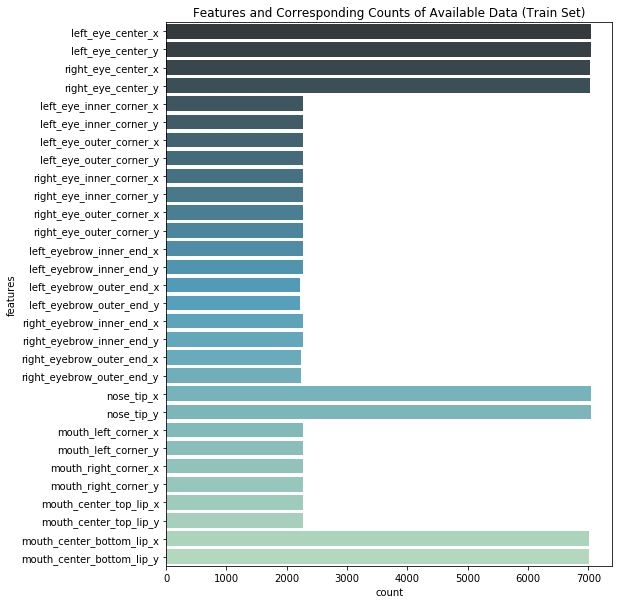

In [24]:
facial_functions.plot_label_counts(labels)

We take a similar look at the test data below, first preprocessing it (again, where the last column contains the pixel values) and then checking for missing values.

In [25]:
# processing test data such that each pixel has its own column
kaggle_test = facial_functions.preprocess_pixels(df_test)
kaggle_test.head()

0    1    2    3    4    5    6    7    8    9     ... 9206 9207 9208 9209  \
0  182  183  182  182  180  180  176  169  156  137  ...    6   14   28   28   
1   76   87   81   72   65   59   64   76   69   42  ...  156  152  162  169   
2  177  176  174  170  169  169  168  166  166  166  ...    1    1    1    1   
3  176  174  174  175  174  174  176  176  175  171  ...  144  143  141  142   
4   50   47   44  101  144  149  120   58   48   42  ...  254  254  254  253   

  9210 9211 9212 9213 9214 9215  
0   24   18   12    8    5    5  
1  168  159  191  228  211  168  
2    1    1    1    1    1    1  
3  143  142  142  142  142  140  
4  255  236  174  175  175  165  

[5 rows x 9216 columns]

We note the dimensions of our training data vs testing data: 
* As expected, there are 9216 (96 x 96 pixels) columns in both sets to represent our images. 
* Training data has a total of 7049 images, while the testing data has a total of 1783 images. 

In [26]:
# We check that we have the correct shapes
print("Train data shape:", kaggle_train.shape)
print("Test data shape:", kaggle_test.shape)

Train data shape: (7049, 9216)
Test data shape: (1783, 9216)


Below, we check that we have no missing values in our test set pixels.

In [27]:
print("Missing values pixel data:", kaggle_test.columns[kaggle_test.isnull().any()].tolist())

Missing values pixel data: []


To get a sense of what the images look like along with their facial keypoints, we proceed to plot 20 images with the corresponding facial keypoints.

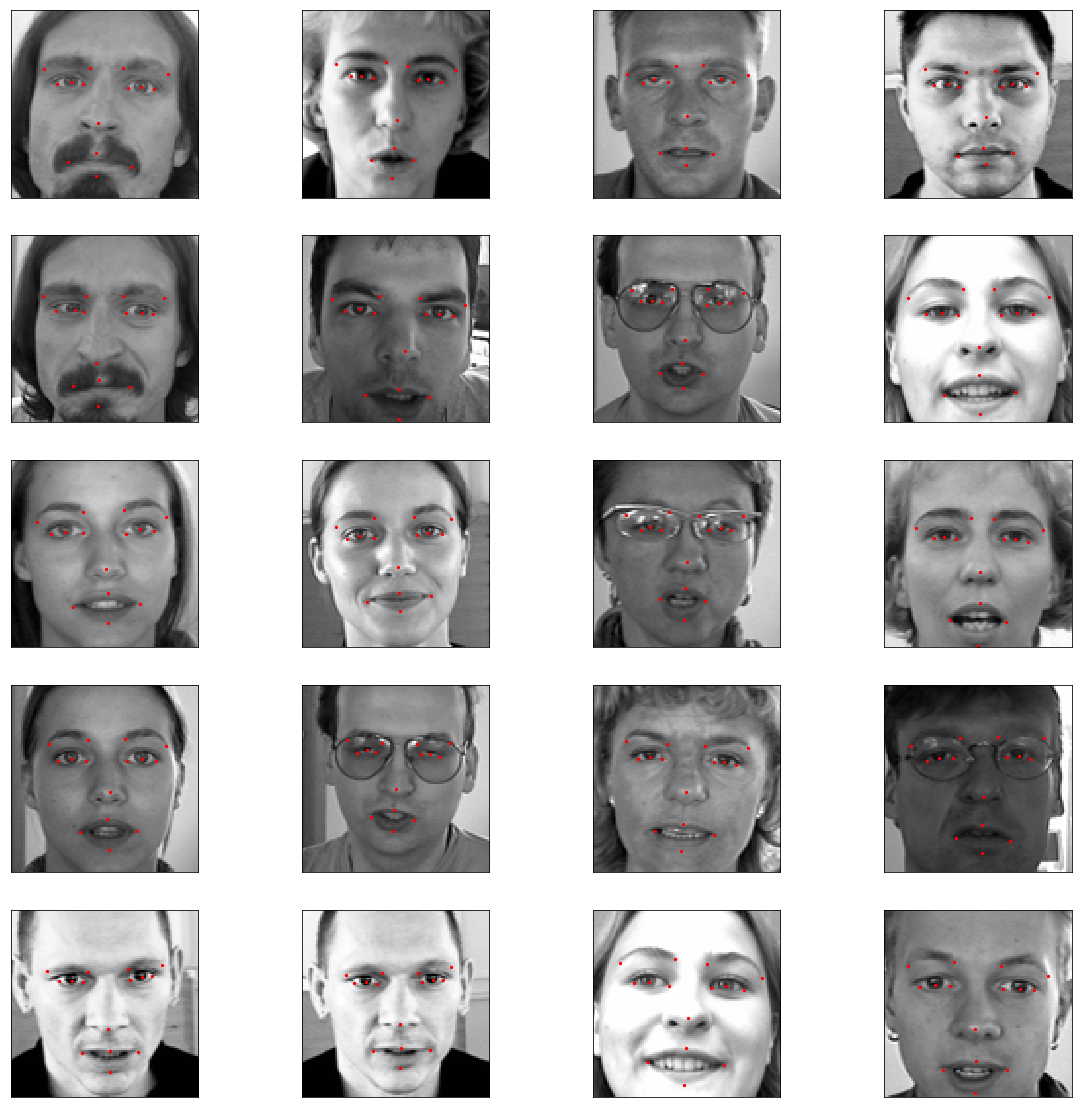

In [28]:
# Plotting some of the image data with keypoints
position = 1

fig = plt.figure(figsize = (20, 20))

for index in range(20):
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96)), cmap = 'gray')
    
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1

plt.show()

To get a sense of images with missing facial keypoints, we plot a few of them below. 

In particular, we note the following: 
* Some facial features are cut off at the image border and therefore are 'missing'. 
* Facial orientation (i.e. sideview) can distort what features are visible 
* Items such as glasses and hair can block facial features, and thus are 'missing'.

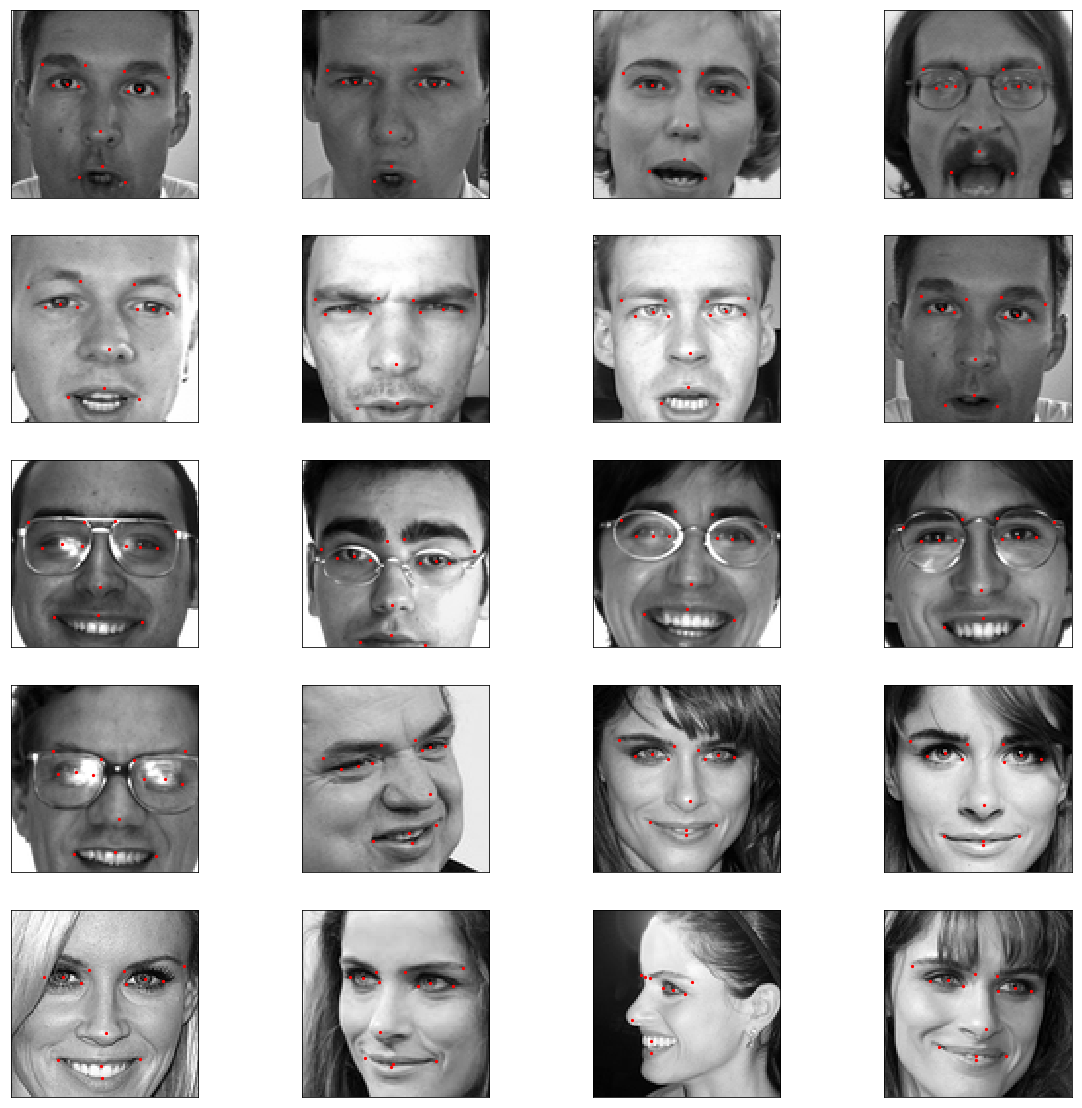

In [29]:
# Plotting some images with missing keypoints 
position = 1

fig = plt.figure(figsize = (20, 20))

for index in range(labels.shape[0]):
    
    if sum(labels.iloc[index,:].isnull()) == 0:
        continue
        
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96)), cmap = 'gray')
    
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1
    
    if position > 20:
        break

plt.show()

## Baseline Model##

In this section, we illustrate regressing the coordinates of facial key points using a simple neural network model with no hidden layer as our baseline model. The purpose of the baseline model is to compare and contrast the improvement of our classifer with our data augumentation and feature engineering in the subsequent sections.  We will also use the baseline model to evaluate the performance of extending on the neural network's architecture, e.g. by adding hidden layers.  

### Data Transfomation

We first drop all the images that contains one or more missing facial keypoint values.  From the EDA section, we identified only 2,140 images out of the total 7,049 with all 30 facial keypoint intact.  We refer to these images as "High Quality" and will run our baseline CNN model based on this subset of images.  We ran through a list of codes below to transform the data into our desired shape and format. 

In [30]:
# We drop all images with mising value which left us with 2140 images. 
# We normalize the data so that pixel values range from 0-1 instead of 0-255
# We examine the shape of the data to make sure that it is correct. 
norm_x_train, labels_no_na, non_na_index = facial_functions.separate_non_missing(kaggle_train, labels, normalize=True)

Correct shape for train features? (2140, 9216)
Correct shape for train labels? (2140, 30)


### Splitting Data into Train and Test 

As the Kaggle test set comes without labels, we will use the training data and split the data into a validation set and a training set. The validation set is used to compare the performance of different model specifications on the same unseen test data.

In [31]:
train_data, train_labels, val_data, val_labels = facial_functions.split_train_and_test(norm_x_train, 
                                                                                       labels_no_na, 
                                                                                       percent=.8,
                                                                                       seed=123)

validation set shape (20%): (428, 9216) (428, 30)
train set shape (80%): (1712, 9216) (1712, 30)


In [32]:
train_data, train_labels = facial_functions.reshape_image(train_data, train_labels, "train")
val_data, val_labels = facial_functions.reshape_image(val_data, val_labels, "val")

train feature shape (1712, 96, 96, 1) train labels shape (1712, 30)
val feature shape (428, 96, 96, 1) val labels shape (428, 30)


### Model Building

We instantiate a sequential model with no hidden layer as our baseline model with most of the default hyperparameters.  We select the activation function `relu`, as it should optimize beyond a certain threshold. The output dimension is 30 as there are 15 pairs of x, y coordinates and the imput dimension is 9,216 representing the 96 x 96 pixel dimensions. We then run the optimizer, setting the learning rate to be 0.01 and using 100 epochs, to calculate the accuracy and loss of our baseline model.  
We plot out our baseline model accuracy on training and validation data. As indicated by the plots below, the root mean square error decreased slightly over the number of epochs, with bumps around 60 to 70 epochs. In addition, the performance seems to plateau after around 70 epochs.  This might indicate that our model does not learn well with the increasing number of epochs. **The result suggests that we are likely to improve our model performance by introducing additional layers**. 

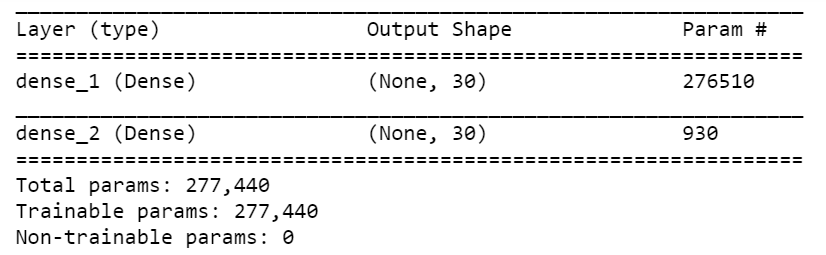

In [3]:
# base_model, total_time = facial_functions.run_baseline_model(train_data, train_labels, val_data, val_labels, epochs=100, lr=.01, seed=123)
Image(os.path.join(workDir, "images/Baseline_summary.png"))

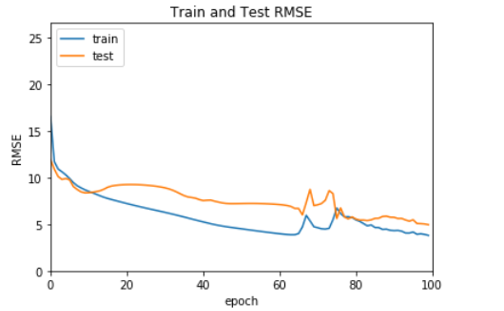

In [2]:
Image(os.path.join(workDir, "images/baseline_plot.png"))

Next, we put our predicted labels on the facial images to see how they perform.

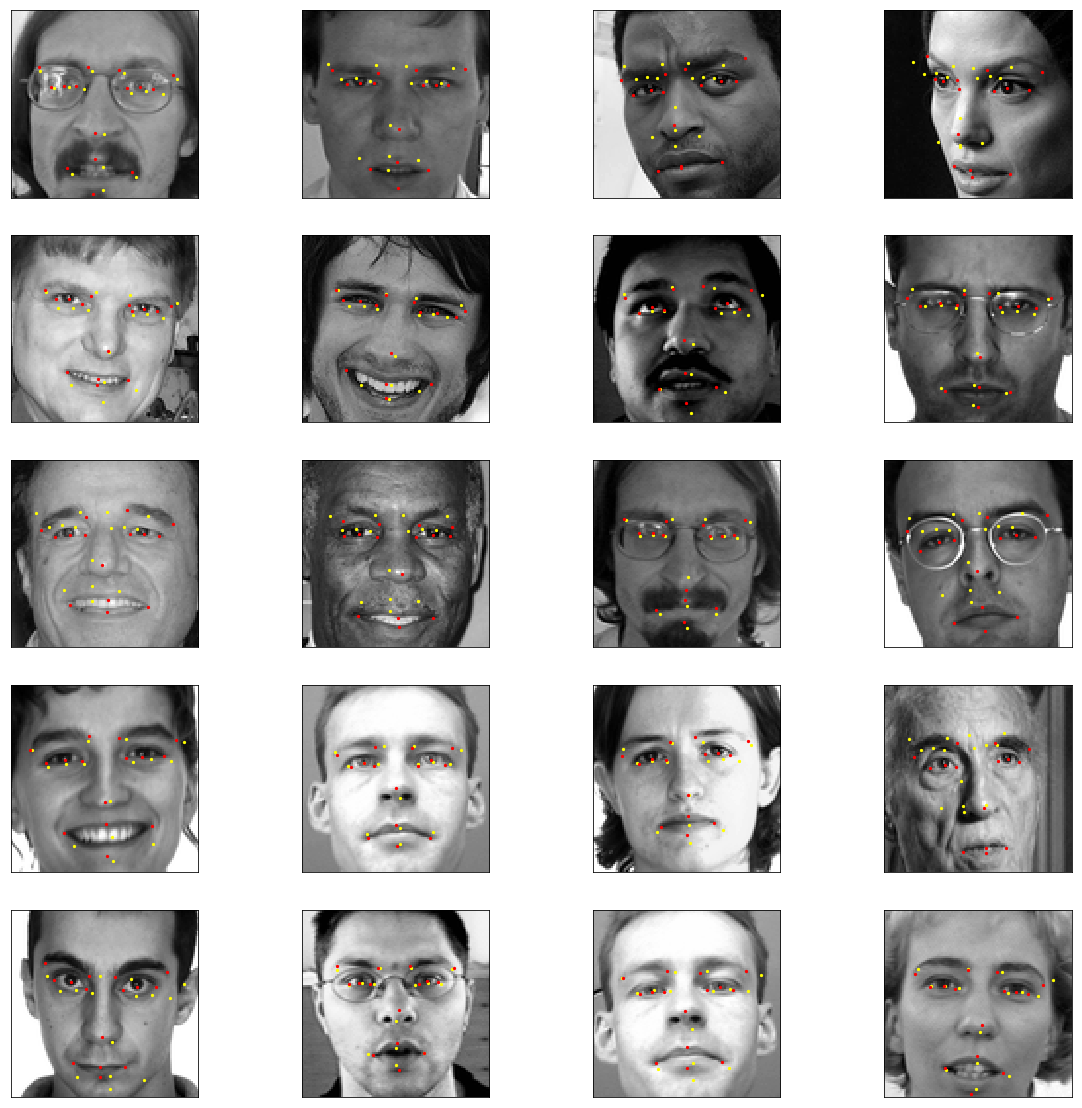

In [36]:
# We plot the prediction with facial images; yellow: prediction, red: actual
position = 1

model = load_model('models\\baseline_model.h5', 
                   custom_objects={'r_square': facial_functions.r_square, 'rmse': facial_functions.rmse})

fig = plt.figure(figsize = (20, 20))

for index in range(20):
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(val_data[index,:].reshape(1, -1), (96,96)), cmap = 'gray')
    
    prediction = model.predict(val_data[index,:].reshape(1, -1))
    
    for coord in range(0, 30, 2):
        plt.gca().scatter(prediction[0][coord], prediction[0][coord+1], c = 'yellow', s = 5)
        plt.gca().scatter(val_labels[index, coord], val_labels[index, coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1

plt.show()

As expected, the facial images with any kind of distortation (e.g. face tilted to an angle, raising eyebrows) or obfuscation (e.g. hats, sunglasses, bangs) are particulary inaccurate in how the keypoints are predicted.   

## Sectional Summary

From the accuracy and loss plots above, it's apparent that our model learns little and therefore the performance is weak on the validation set.  The predicted labels are in their shape fairly similiar regardless of the images, suggesting that the model's learning rate plateaued after several epochs.  Below are a few key reasons for our baseline model's poor performance and the key challenges that we will tackle in the subsequent section.

- **Challenge #1: Suboptimal model performance**: The model performance plots show that validation RMSE decrease plateaued after several epochs. This suggests that we need to modify our CNN by introducing hidden layers or changing the hyparameters.

- **Challenge #2: Insufficient training data**: Our EDA shows that only 2,140 images have all labels intact.  By excluding images with missing labels, we reduced our training data size by 70%.  

- **Challenge #3: Inconsistent image quality**: As shown in the images above, our model is weak in predicting facial images that are distorted, tilted or obfuscated. We will need to reprocess these images by introducing additional features, by data augmentation or by expanding teh model infrastructure to allow the model to learn higher abstractions of facial parts.


***

# Part II


## Challenge #1 and #3: Tackling suboptimal model performance through model infrastructure

###  Attempt 1:  Incorporating CNN (Basic CNN Model)

In the next sections, **we will explore methods to improve our model through expanding on the model architecture and through feature engineering and data augmentation to increase our training set**. 

We will introduce additional layers with hyperparameters and number of neurons that we consider to be optimal for the training set and compare the performance with our baseline model.   

Initially we faced difficulty feeding the image vectors into the model. We used the Keras library with a Tensorflow (TF) backend. The backend options of TF and Theano are mostly interchangeable without much difficulty. However when it comes to image processing, the default input parameters for the two backends vary. The default color parameter in Theano comes first (color parameter, x-axis array, y-axis array), meanwhile TF expects the color parameter after the image specifications. 

The convolution layers apply a filter and reduce the feature set. **The structure and the parameter values we arrived at are based on an empirical approach combined with rules of thumbs developed by other practitioners in the field** (e.g. Xudong Cao, "A Practial Theory for Designing Very Deep CNNs"). The small receptive field (kernel size = (3, 3)), small incremental strides and the expanding depth of the convolutional layers achieved better results. The stepwise increase in the depth of the convolutional layers allows the neural network to increase the capacity to learn without down sampling and find an increasing number of spatial relationships in the data. 

We used an empirical approach to decide how many neurons to add in the fully connected layers, and varying the numbers between 100 and 500 did not change the result. The choice of `ReLU` activation layers speeds up the learning rate at the different layers. Building on what we learnt from the baseline model, maintaining the ‘softmax’ activation function for the final thirty neuron output layer allowed for a smoother learning rate.

Please note that we commented out the code to run the model due to the long run time under a CPU. We run all models using Google's GPU via collab. We saved the model objects as well as made screenshots of the architecture of teh model and the performance development. As side note, we tried using the TPUs as well, but for our models, the GPU was faster, which might be due to memory restrictions for the TPUs. 


In [37]:
#cnn_model, cnn_total_time = facial_functions.run_cnn_model(train_data, train_labels, val_data, val_labels, 
                                                        #epochs=130, lr=.01, baseline=model[1], seed=123)

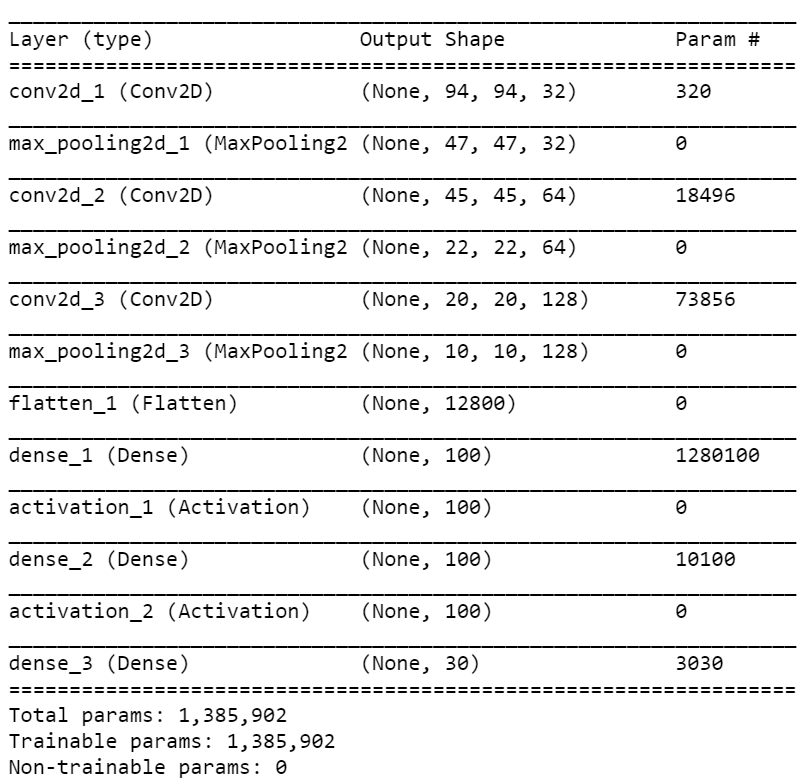

In [38]:
Image(os.path.join(workDir, "images/CNN_summary.png"))

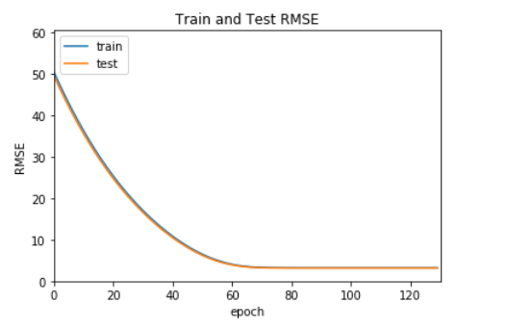

In [4]:
Image(os.path.join(workDir, "images/CNN_plot.png"))

We noted a good performance increase of over 36% compared to the baseline and a much smoother learning.

### Attempt #2:  Adding Dropout and Batch Normalization (Regularized CNN)

In a further attempt to improve the performance by changing the model infrastructure, we incorporated dropout and batch normalization to increase variance and hence, possibly, increase performance on the validation data.

**Batch normalization** reduces the amount by what the hidden unit values shift around (covariance shift) by normalizing the magnitude of inputs so that your network does not favor one input over another simply due to scale. This technique also speeds up the model training process.

**Dropout** randomly turns off a percent of edges so that your model does not get overly dependent on just a couple features. This is a widely used mechanism to fight overfitting.

In [40]:
#new_cnn_model, new_cnn_total_time = facial_functions.run_regularized_cnn_model(train_data, train_labels, val_data, val_labels, 
                                                        #epochs=250, lr=.0005, batch_size=50, dropout=.1, baseline = model[1])

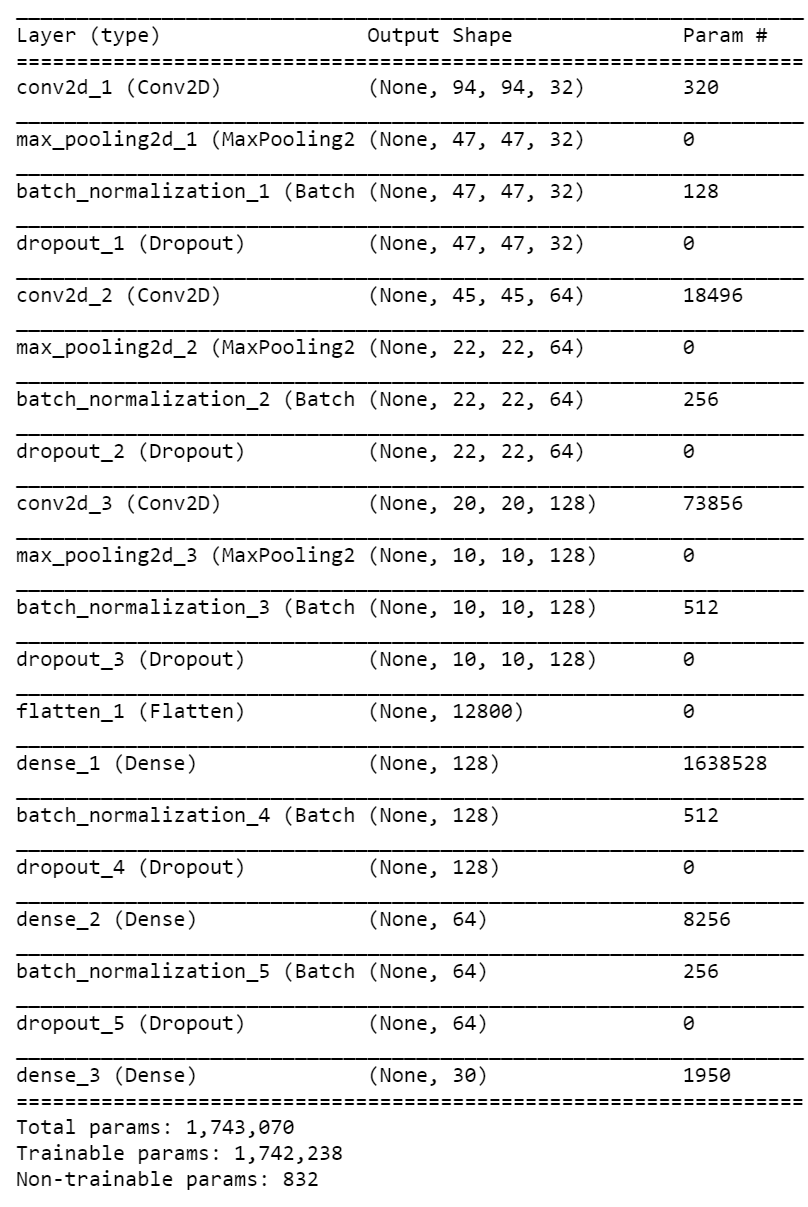

In [41]:
Image(os.path.join(workDir, "images/regularized_CNN.png"))

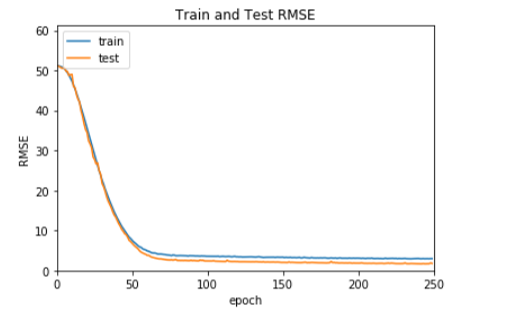

In [5]:
Image(os.path.join(workDir, "images/regularized_CNN_plot.png"))

We indeed increased our performance on the validation set significantly compared to baseline (by over 64%) and compared to teh previous CNN model. Hence, increasing variance helped our prediction.

## Challenges #2 & #3: Takling Insufficient Training Data and Inconsistent Data Quality

### Attempt 1:  Image Distortion

When working with smaller datasets, data augmentation is a promising technique that can enable better results. It boils down to increasing the number of training examples by applying transformations to available data with the hopes that it will increase our training set and allow your model to have more training examples.

#### Rationale

To increase the training data set we plan to **transform the images and the associated facial point locations**. Since we want our model to learn meaningful characteristics about the anatomy of a human face, as opposed to relying on repeated locational patterns (e.g. left eye usually being located in top left of image), we believe that applying transformations like rotation, flipping, and angling can help our model build a better representation of a human face. This approach looks like the following transformed images:

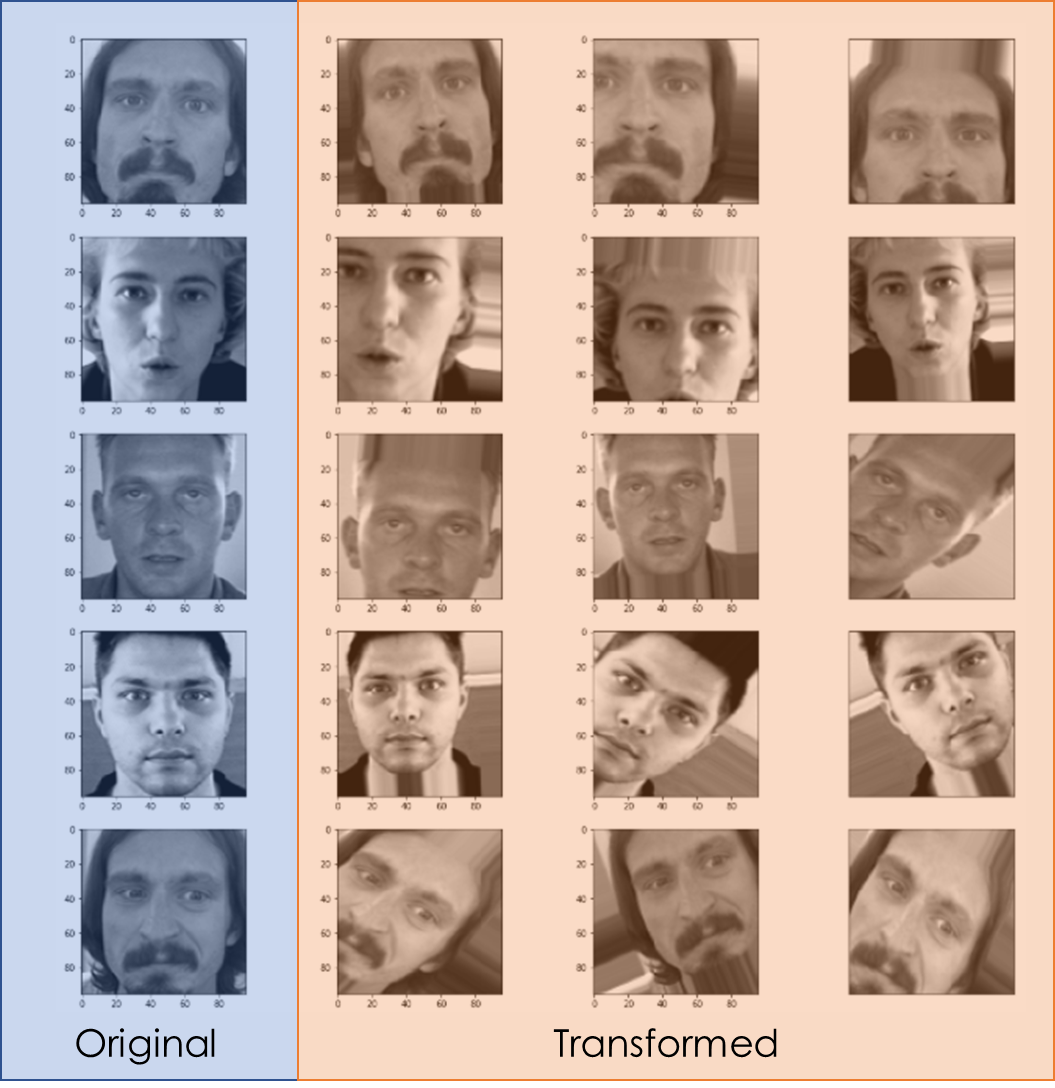

In [43]:
Image(os.path.join(workDir, "images/data_augmentation_original_concept.png"))

Below is the commented out code we used to create computer generated images:

In [44]:
# aug_train_data = facial_functions.generate_new_images(train_data, batch_size=10, rotation_range=10).astype(int)
# aug_train_data.to_csv(os.path.join(workDir, "data", "augmented_train_data.csv"))

#### Result

While we were able to generate new modeled images, we hit a roadblock in being able to translate distortions to our labels. Image augmentation techniques like the one described above are very effective in image classification problems; however, in a multivariate regression problem, like we have, implementing data augmentation becomes increasingly difficult. This is an important distinction, and here is why: in a standard image classification problem, let’s say “is this an image of a cat”, the label that we are trying to learn is whether or not the image contains a cat. If we apply transformations like rotating, flipping, or angling to the images, the label remains unchanged. In this facial feature detection problem, our labels are the pixel location of the features (X and Y coordinates). This makes the applying of data augmentation transformation to the images much harder because the same transformations would need to be applied to our labels too. Therefore, the data distortion as-is could not be used directly for information gain in the model learning process for facial key points. However, we were able to combine this method with a separate technique to use augmented data in our models.

### Attempt 2: Imputing Feature Location and Adding Missing Keypoints

#### Rationale
We look into **imputing the missing coordinates of the transformed facial features**. Specifically, we look at Adam Geitgey's package face_recognition (https://github.com/ageitgey/face_recognition). Given an image, face_recognition provides an output of 68 labelled points (each with x,y coordinates) corresponding to the eyebrows, eyes, nose bridge, nose tip, upper lip, lower lip, and facial jaw outline. 

Given that we have such a small set of images with a full complete set of all 15 labelled facial keypoints, we felt that some introduced bias in the presence of getting more data is worth it in order to get more training data for the CNN model. We expect the added transformation of images will increase our model performance by expanding the training data set. 

#### Challenge

The challenge with utilizing a foreign package includes the following: 
* Condensing the relevant points within the provided 68 labelled points into 15. While this is easy for some features (i.e. eyebrows and eyes), the keypoints on the mouth are definitely harder in particular when the face is tilted or shifted a certain way. 
* We may be introducing extra bias as the keypoints determined by an external package may be different than how the original facial keypoints were created. 



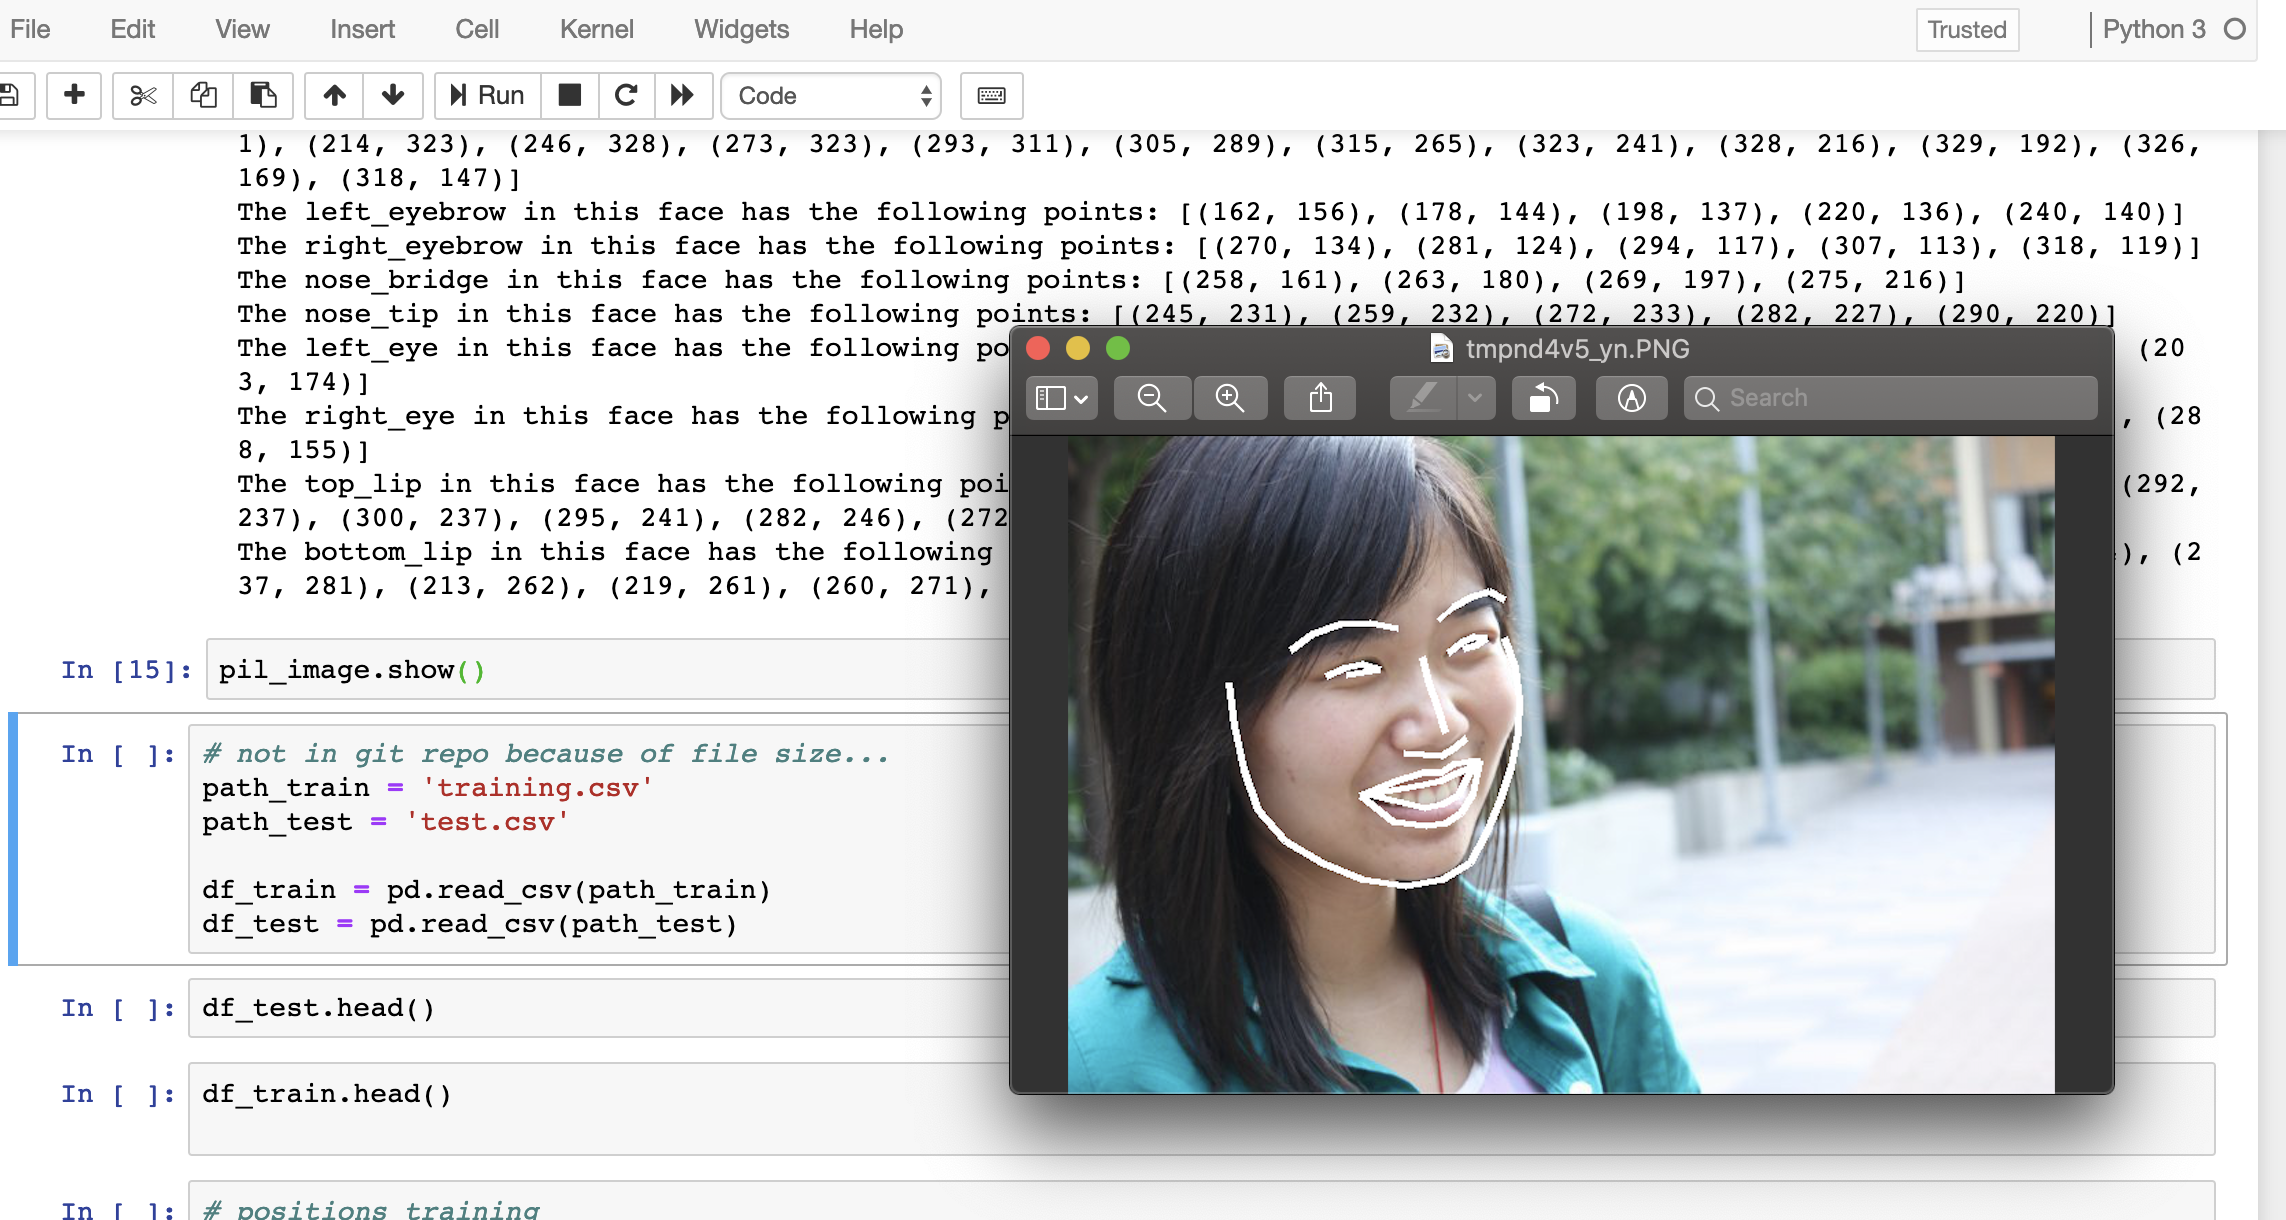

In [45]:
Image(os.path.join(workDir, "images/vivian_screenshot.png"))

Below is the commented out code we used to impute the missing labels and information about the results:

In [46]:
##################
# Don't run this unless you want to install face_recognition 
##################

#import dlib
#import face_recognition #https://github.com/ageitgey/face_recognition 

#data = pd.read_csv("augmented_train_data.csv")
#data_df = data.drop(['Unnamed: 0'], axis=1)

#**Note**: You can input here whichever file you are looking at 
#Ex: You can input in the original training.csv (kaggle_train in our case) 
#For this particular segment of code, data_df comes from loading the "augmented_train_data.csv" 

#unable_list=[] #this holds indexes where we are unable to get coordinates 

#new_coordinates = [] #this holds the new coordinates 

#for index, row in data_df.iterrows(): 
#    array_image = get_image_and_save(index) 
#    array_image.save('foo.jpg')
#    image_test = face_recognition.load_image_file("foo.jpg")
#    image_test_labels = face_recognition.face_landmarks(image_test)
#    if (len(image_test_labels)==0): #face_recognition was unable to detect anything
#        unable_list.append(index) #append index 
#    else: 
#        created_labels = make_points(image_test_labels, index)
#        new_coordinates.append(created_labels)

#new_labels = []
#for i in range(len(new_coordinates)): 
#    new_labels.append(pd.DataFrame(new_coordinates[i]).T)

#edited_labels_df = pd.concat(new_labels).reset_index(drop=True)

#edited_labels_df['row_index']=edited_labels_df['row_index'].astype(int)

#edited_labels_df.to_csv('augmented_train_data_predicted_coordinates.csv', index=False) #spit out new imputed points

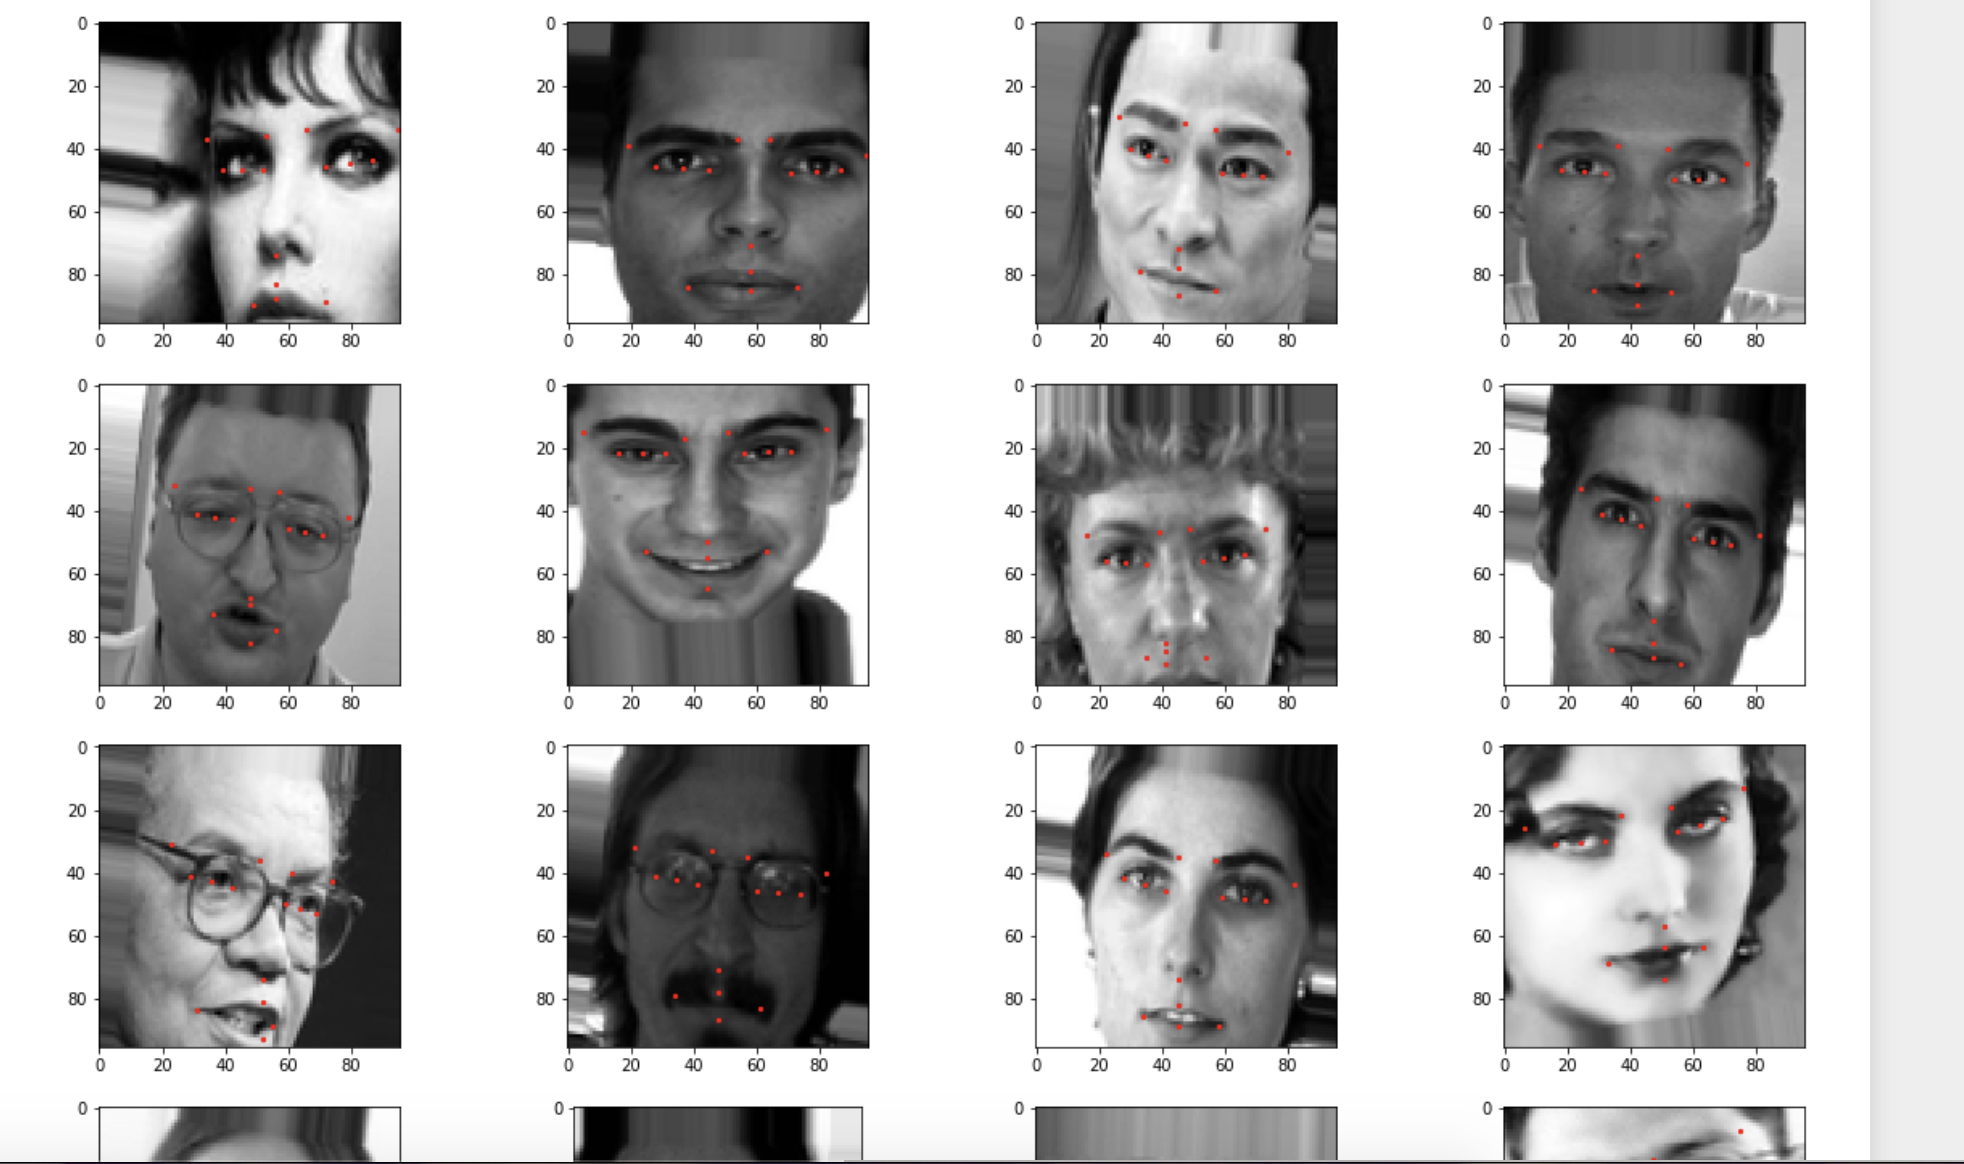

In [47]:
Image(os.path.join(workDir, "images/vivian_results.png"))

#### Result

In total, face_recognition was able to salvage an additional 4,241 images, providing us with a total of 6,381 images with a full labelled set of 15 facial features each with x,y coordinates. Only 668 images were left incomplete. We were also able to impute labels for 12,490 model generated images.

## Attempt 3: Regularized CNN with Augmented Data

Through the techniques described above, we wanted to use our three sets of possible training data to built the most robust model we could. The three datasets included the following: regular training data, data with missing labels that were later imputed, and, lastly, model generated faces that had imputed feature labels.

In order to do this, we combined all three datasets and fed them into our best model architecture--the regularized cnn model. While building this model, we noticed that our validation RMSE was not improving from our last best model described above; however, we still believed that this model, with a much larger dataset, could outperform the previous model when using Kaggle's competition test set as the base. Our validation dataset only includes cleaned data, and with an already small dataset that also included different images of the same person in different poses (without a way to separate them), we didn't want our model to overfit to our training data--and remember specific people's faces--yet get credit for it on the validation score.

Knowing this, we realized that a more robust, and better, model could actually increase **val_rmse** and that the true test of model performance would come from the kaggle provided test set.

### Data and Model Parameters

After some attempts, we decided that the model generated images created too much noise for the model; therefore, we removed this subset of data from training. As for the data with missing labels that were recovered (4,241 images), we kept those in. Additionally, we noticed that while using the recovered images for training, our model tended to favor predicting points that aligned to turned face as opposed to a frontal-facing headshot; due to this, we decided to change the distribution of data by oversampling images from our original training dataset. All in all, we trained this last model with 16,232 images (fyi, we shuffled the images during training) and the following parameters:


In [6]:
# new_cnn_model_w_aug_data, new_cnn_w_aug_data_total_time = facial_functions.run_regularized_cnn_model(new_attempt_train_features, new_attempt_train_labels, val_data, val_labels, 
#                                                                             epochs=250, lr=.5, batch_size=500, dropout=.5)

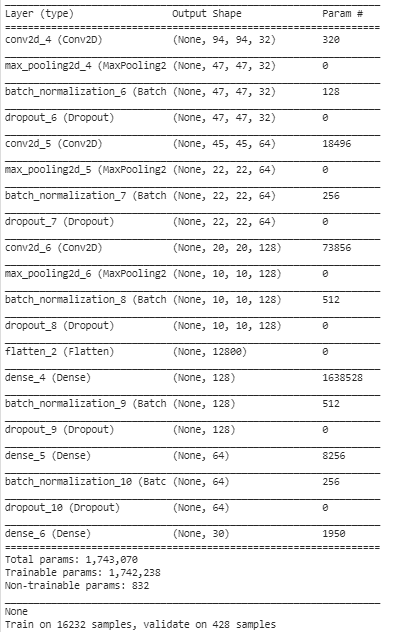

In [7]:
Image(os.path.join(workDir, "images/regularized_CNN_w_aug_data.png"))

### Model Checkpoint Savings (like Early Stopping)

Using the new training data, we kicked off a model for 250 epoch; however, since learning for this model was very shaky given the added noise, we chose to run a model checkpoint save whenever the model reached a newest best **val_rmse**. This enabled us to have the weghts saved for the model with out best accuracy estimator as opposed to only saving the last epoch.

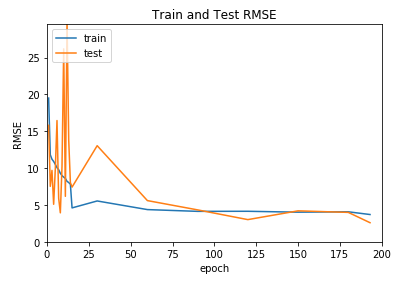

In [10]:
Image(os.path.join(workDir, "images/regularized_CNN_w_aug_data_plot.png"))

#### Result

This model failed to beat our best **val_rmse** from before; however, we knew that the best gauge for model perfomance would come from the test set provided by the kaggle leaderboard. As for learnings, we discovered that the distribution of turned faces to fontral face images had a significant impact on model performance, which triggered us to oversample from the standard training data to offset these undesired biases. Also, introducing a model checkpoint save enabled us to save the weights for our best model run as opposed to only having the last epoch.

# Expansion: Combining Classification and Regression Models

## Rationale 
**An assumption we made in our modeling so far is that our data will always have all facial keypoints present.** This is also how Kaggle provided the test set: It is marked which keypoints are present and will need to be predicted. However, in reality this assumption might not hold. Hence, we think it might make sense to install a **classification model to predict which keypoints are present** and **then run a regression model on the keypoints classified as being present**. To do that we will use two CNN models. Besides the last layer for the classification model, both models will have the same architecture as the last CNN model we added with dropout and batch normalization. Thus, for the classification we predict whether a coordinate is present or not.

## Process
The last layer of the classification model will have a sigmoid activaition function to output the probabilities and treat the loss of each node individually. In addition, the model will use a binary crossentropy loss function as we assume that each class will be independent and will either be present or not present.

We will then adjust for the independence assumption as each keypoint has a x- and y-coordinate. In case the model predicts a sufficiently high probability for both x- and y-coordinate being present, only then will we assume the keypoint is present. Otherwise, if either coordinate's probability of being present is too low, the keypoint is set to zero, which we equate with missing.

We combine the predictions of the classification and the regression model by classifying and regressing on an image independently, then adjusting the classifications based on the threshold probability and finally combining both predictions by elementwise multiplication on the prediction matrices. The resulting matrix will yield the regresison coordinates of the keypoints we estimate to be present. Missing keypoint coordinates are entered with 0. Finally, we calculate the RMSE on the prediction matrix.

The modelling structure is illustrated in below image.

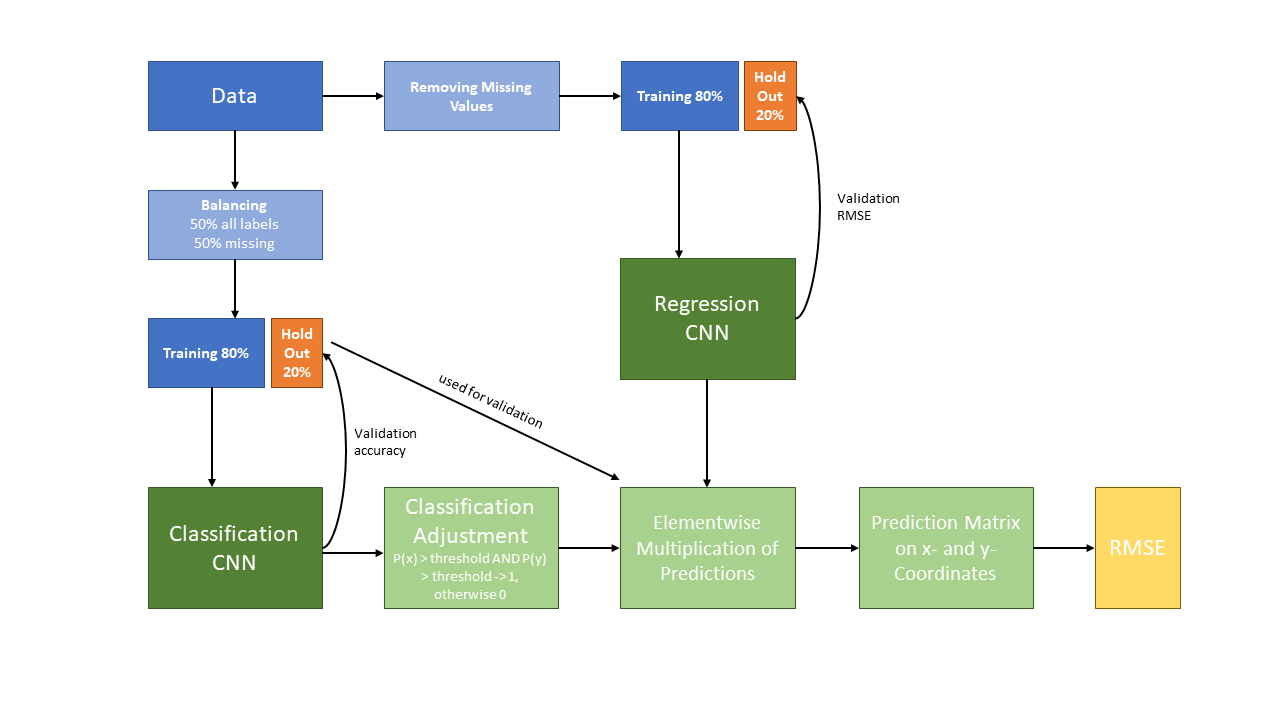

In [48]:
Image(os.path.join(workDir,"images/classification_and_regression.png"))

In [49]:
# preparing the data
x_train, class_labels, x_val, class_val = facial_functions.classification_data_preparation(kaggle_train, labels)

Correct shape for train features? (4280, 9216)
Correct shape for train labels? (4280, 30)
validation set shape (20%): (856, 9216) (856, 30)
train set shape (80%): (3424, 9216) (3424, 30)


In [50]:
# We now train the classification model: For illustration purposes, we have 5 epochs here
# The model we run via a gpu was trained on 100 epochs
cl_model_fitted = facial_functions.run_classification_model(x_train, class_labels, x_val, class_val, epochs=10, lr=.01)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 64)        256       
__________

In [51]:
# Finally, we evaluate the combined model performance on the classification validation set
facial_functions.evaluate_clas_reg_rmse('models\\classification_model.h5', 'models\\regularized_cnn_model.h5', 
                                        x_val, class_val, threshold=0.5)

41.090688732445116

## Result

From the validation results we see that the classification model achives a validation accuracy of 0.8775 with 100 epochs. The regression model used achives a validation RMSE of 2.2452 with 100 epochs as well. We set the threshold for both x- and y-coordinates being assumed as present as the probability of x-coordinate and y-coordinate being both above 50%. By then adjusting the classification predictions and elementwise multiplication with the regression predictions we get a combined RMSE of 41.09 when considering the issue of missing keypoints.

This result shows a much higher RMSE compared to the pure baseline evaluation. The reason might be that there is on average a chance of a wrong prediction with a probability of 12%, provided that our used balanced validation set is a random sample of the population. In case of a wrong prediction, the squared error added to the sum of all prediction errors will be very high.


# Model Performance Analysis

## Model comparison 

Below is the comparison chart for all our models.  The **Regularized CNN** is the best performing model on our validation set with a val RMSE of 1.77. *Please note that our best performing model on the kaggle test set is different*

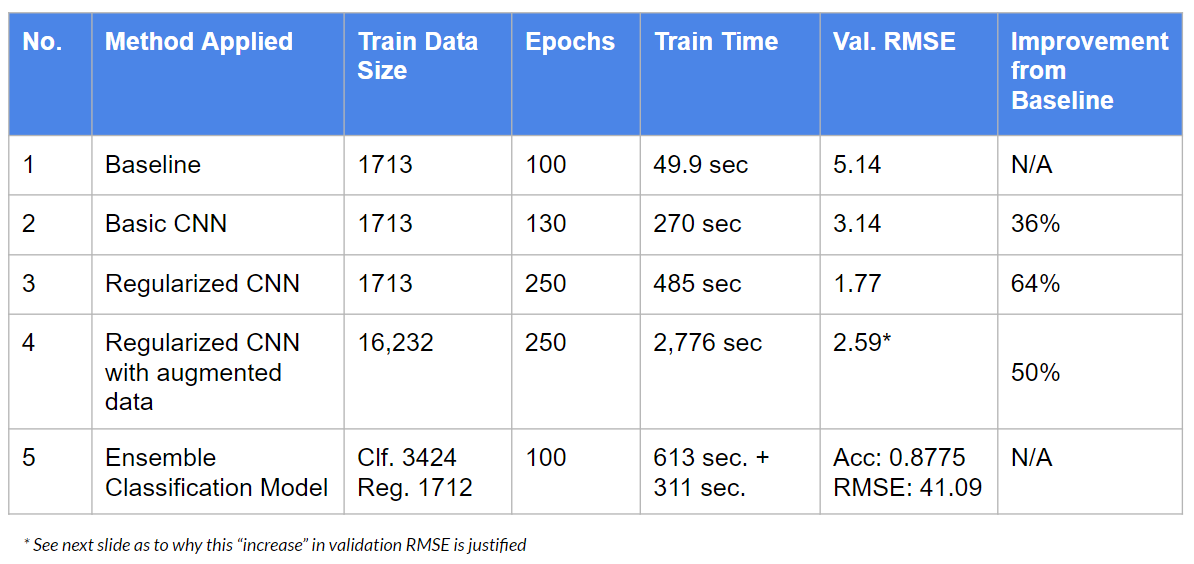

In [11]:
Image(os.path.join(workDir, "images/model_performance_table.png"))

### Leaderboard Performance

To see how our models fare against other teams on Kaggle, we submitted our model result to Kaggle using the below function to save the respective csv submission files. 

In [58]:
#Baseline model submission
facial_functions.create_kaggle_prediction(labels,
                                          'models\\baseline_model.h5',
                                          df_test,
                                          in_path_submission_sheet = os.path.join(workDir, "data", 'IdLookupTable.csv'),
                                          out_path = 'kaggle_submission_baseline.csv', 
                                          baseline = True)

#Basic CNN model submission
facial_functions.create_kaggle_prediction(labels,
                                          'models\\cnn_model.h5',
                                          df_test,
                                          in_path_submission_sheet = os.path.join(workDir, "data", 'IdLookupTable.csv'),
                                          out_path = 'kaggle_submission_cnn.csv')

#Regularized CNN model submission
facial_functions.create_kaggle_prediction(labels,
                                          'models\\regularized_cnn_model.h5',
                                          df_test,
                                          in_path_submission_sheet = os.path.join(workDir, "data", 'IdLookupTable.csv'),
                                          out_path = 'kaggle_submission_reg_cnn.csv')

#Augmented CNN model submission
facial_functions.create_kaggle_prediction(labels,
                                          'models\\best_regularized_cnn_w_aug_data_model_v13.h5',
                                          df_test,
                                          in_path_submission_sheet = os.path.join(workDir, "data", 'IdLookupTable.csv'),
                                          out_path = 'kaggle_submission_reg_cnn.csv')

Below is the comparison chart for all our models.  The **Regularized CNN with Augmented Data** is the best performing model on the *Kaggle-provided test set* with a test RMSE of 3.345. *Please note that our best performing model on our group-created validation set is different*

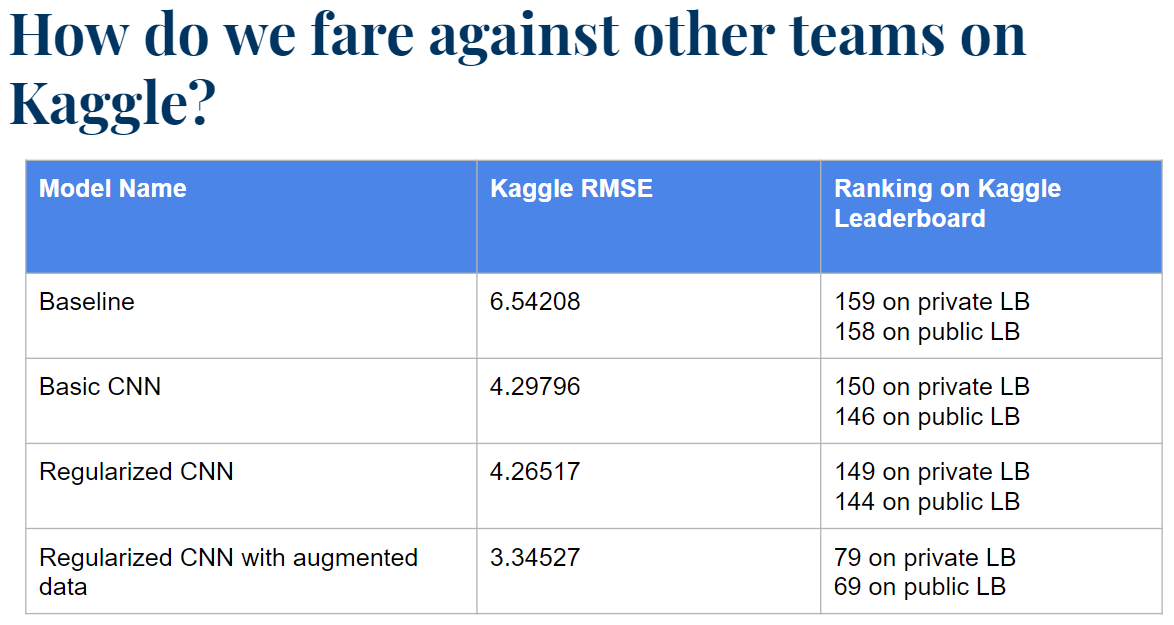

In [9]:
Image(os.path.join(workDir, "images/leaderboard.png"))

We see that the enhanced CNN model trained on the augmented data performs best. This is also what we would have expected. 

##  Conclusion


The problem we tried to solve in this project is to predict key points for a given set of images. The initial EDA and baseline model revealed several challenges associated with the dataset, namely, suboptimal baseline model performance, insufficient training data, and inconsistent data quality.  We used data augmentation and convolutional neural network to improve model performance.  In our best attempt, regularized CNN model with augmentated data, we were able to achieve a 50% improvement from baseline and a Kaggle test data RMSE of 3.345 (which would've placed us at 69th and 79th on the public and private leaderboards, repectively).  

We were able to improve our baseline model by 64% on our own validation data by simply introducing additional CNN layers, adding dropout and batch normalization and change the model parameters.  The most challenging process for us was the data augmentation process, in which we tried (and failed) several attemtps in flipping, rotating, and incorproating external tools for enhancing the key points locations.

As extension of the problem, we also created a model ensemble of classification and regression in order to predict for any given image in a 96x96 pixel format which key points are present and then predict the key point coordinates. The RMSE was naturally much higher on the validation set, as teh classification was not perfect (around 90% accuracy on validation set).

As further extensions of our project's work we thought about training a single layer of our CNN using eigenvectors of the faces. In addition, using horizontal flipping on the augmented images would also double the training size. The concept will be described in the appendix section.

Our conclusion is that **modeling is easy but understanding the subtlety of the underlying data is challenging.** 


# Appendix

## Next step  - What we would try in addition, if we have more time

The current state of the art models use fully convolutional networks (FCN) which allow for pixel by pixel segmentation of the image. Here is an example (souce:https://github.com/divamgupta/image-segmentation-keras):

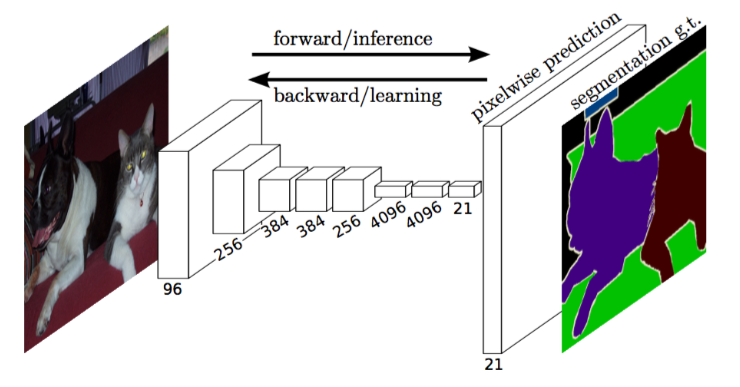

In [55]:
Image(os.path.join(workDir, "images/diva.png"))

We can apply this approach the facial points’ detection problem by modifying the approach. First, we create Gaussian kernels around the projected facial point. Then we can up-sample the kernel using the Keras library to improve the image quality of the magnified kernel and feed the output through an FCN to segment the input pixel by pixel. 

There are certain roadblocks in this approach, firstly the varying angles and augmentations of the images would produce variance in the kernel and secondly, we will need to minimize three loss functions. The difference between the true kernel and the estimated kernel, secondly, the difference between the estimated kernel and the projected facial point and thirdly, the difference between the true kernel and the projected facial point. 

If the problem of minimizing the three loss functions can be solved the benefit of upsampling the image to segment the image may improve the result substantially.    